# Import packages

In [493]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import datetime as dt
import glob, os, pickle, json
import pymongo
from bson.objectid import ObjectId

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
    
def get_records(mongo_client, database_name, collection_name, query):
    collection = mongo_client[database_name][collection_name]
    response   = collection.find(query)
    records = tuple(doc for doc in response)    
    return records

path_caco_runwise = "/home/juan/projects/CaCo_TCU_databases_sync/caco_run_information"
query = None

date_start = datetime.fromisoformat("2024-02-06-00:00:00")
date_stop  = datetime.fromisoformat("2024-02-20-00:00:00")

query_tcu = {"tstart": {"$gte": date_start.timestamp()}, "tstop": {"$lte": date_stop.timestamp()}}
query_tcu_chunks = {"begin": {"$gte": date_start}, "end": {"$lte": date_stop}}
query_caco = {"date": {"$gte": date_start, "$lte": date_stop}}
query_caco_runs = {"start_time": {"$gte": str(date_start)}, "stop_time": {"$lte": str(date_stop)}}

read_db = True

## TCU.lst1_obs_summary database

In [392]:
print("Reading TCU database")
client_tcu  = pymongo.MongoClient("localhost:27017")
records_tcu  = get_records(client_tcu,  "lst1_obs_summary", "camera", query_tcu)
print(f"Found {len(records_tcu)} records for the TCU DB in the specified query.")

# Splitting in subsets depending on kind of datataking specification
mask_drs4     = [r["kind"] == "calib_drs4" for r in records_tcu]
mask_pedestal = [r["kind"] == "calib_ped_run" for r in records_tcu]
mask_dtaking  = [r["kind"] == "data_taking" for r in records_tcu]

records_tcu_drs4     = np.array(records_tcu)[mask_drs4]
records_tcu_pedestal = np.array(records_tcu)[mask_pedestal]
records_tcu_dtaking  = np.array(records_tcu)[mask_dtaking]

Reading TCU database


In [331]:
tstart_tcu_drs4, tstart_tcu_pedestal, tstart_tcu_dtaking = [], [], []
tstop_tcu_drs4, tstop_tcu_pedestal, tstop_tcu_dtaking = [], [], []

for r in records_tcu_drs4:
    tstart_tcu_drs4.append(datetime.fromtimestamp(r["tstart"]))
    tstop_tcu_drs4.append(datetime.fromtimestamp(r["tstop"]))
for r in records_tcu_pedestal:
    tstart_tcu_pedestal.append(datetime.fromtimestamp(r["tstart"]))
    tstop_tcu_pedestal.append(datetime.fromtimestamp(r["tstop"]))
for r in records_tcu_dtaking:
    tstart_tcu_dtaking.append(datetime.fromtimestamp(r["tstart"]))
    tstop_tcu_dtaking.append(datetime.fromtimestamp(r["tstop"]))

## TCU database for LED intensity

In [462]:
client_tcu.bridgesmonitoring.list_collection_names()

['logs.locks', 'chunks', 'properties', 'logs']

In [494]:
colection_tcu = client_tcu.bridgesmonitoring.chunks.find(query_tcu_chunks)    
  
# dict_keys(['_id', 'property_type_desc', 'component_type', 'meta', 'chunk_size', 'property_type', 'property_name', 'component_name'])
for d in colection_tcu[:1]:
    print(d)

KeyboardInterrupt: 

In [ ]:
collection_tcu_chunks = client_tcu.bridgesmonitoring.chunks.find(query_tcu_chunks)
collection_tcu_properties = client_tcu.bridgesmonitoring.properties.find()

collection_tcu_properties = []
for d in collection_tcu_chunks:
    doc_prop = [i for i in client_tcu.bridgesmonitoring.properties.find({"_id": d["pid"]})][0]
    collection_tcu_properties.append(doc_prop)

print(f"Chunks size: {len(collection_tcu_chunks)}\nProperties size: {len(collection_tcu_properties)}")

In [498]:
collection_tcu_chunks = client_tcu.bridgesmonitoring.chunks.find()

collection_tcu_properties = []
for d in collection_tcu_chunks[:2]:
    print(d["pid"])

5f11d0c734ff9901d198eeac
5f11d0d034ff9901d198f087


In [499]:
d["pid"]

ObjectId('5f11d0d034ff9901d198f087')

#### Reading records of CaCo's and TCU

In [394]:
# def print_tree_structure(client, indent=0):
#     for database_name in client.list_database_names():
#         print(f"{database_name}")
#         db = client[database_name]
#         for collection_name in db.list_collection_names():
#             print(" " * (indent + 2) + f"- {collection_name}")
#             collection = db[collection_name]
#             for document in collection.find()[:1]:
#                 for key, value in document.items():
#                     print(" " * (indent + 6) + f"{key}")
# # print_tree_structure(client_tcu)
# print_tree_structure(client_caco)

#### Reading all hierarchical names

In [398]:
# colection = client_caco.CACO.ECC_min.find(query_caco)
# hierarchical_names = []
# for c in colection[:2000]:
#     hierarchical_names.append(c["hierarchical_name"])
# hierarchical_names = np.sort(np.unique(hierarchical_names))
# print(f"Found {len(hierarchical_names)} hierarchical_names in the database:")
# for h in hierarchical_names:
#     print(h)

## Opening CaCo.RUN_INFORMATION database

In [294]:
docs_runs = []

colection_runs = client_caco.CACO.RUN_INFORMATION.find(query_caco_runs)    
  
for c in colection_runs:
    docs_runs.append(c)
    
print(f"Found {len(docs_runs)} updates in the database")

run_starts = []
run_stops  = []
run_numbers = []
for d in docs_runs:
    run_numbers.append(d["run_number"])
    run_starts.append(datetime.fromisoformat(d["start_time"].replace("Z", "").replace("T", " ")))
    run_stops.append(datetime.fromisoformat(d["stop_time"].replace("Z", "").replace("T", " ")))

Found 295 updates in the database


## Opening CaCo.ECC_min and extracting the LED information

In [406]:
%%time
docs_leds_positions = []
docs_ledX_positions = [[] for X in range(16)]

colection_ecc = client_caco.CACO.ECC_min.find(query_caco)    
    
for c in colection_ecc:
    if c["hierarchical_name"] == "CameraControlDataSaver.CameraControl.ModulesAvailable.ECC.exports.ServerECC.ECC.Monitoring.LEDPositions.GeneralStatus.GeneralStatus_v.GeneralStatus_v":
        docs_leds_positions.append(c)
    for X in range(16):
        if c["hierarchical_name"] == f"CameraControlDataSaver.CameraControl.ModulesAvailable.ECC.exports.ServerECC.ECC.Monitoring.LEDPositions.Led_{X+1:02.0f}.Led_{X+1:02.0f}_v.Led_{X+1:02.0f}_v":
            docs_ledX_positions[X].append(c)

print(f"Found {len(docs_leds_positions)} updates in the database for General LED Status")
for X, docs in enumerate(docs_ledX_positions):
    print(f" - For LED {X+1}: {len(docs)} entries")

Found 188 updates in the database for General LED Status
 - For LED 1: 188 entries
 - For LED 2: 188 entries
 - For LED 3: 188 entries
 - For LED 4: 188 entries
 - For LED 5: 188 entries
 - For LED 6: 188 entries
 - For LED 7: 188 entries
 - For LED 8: 188 entries
 - For LED 9: 188 entries
 - For LED 10: 188 entries
 - For LED 11: 188 entries
 - For LED 12: 188 entries
 - For LED 13: 188 entries
 - For LED 14: 188 entries
 - For LED 15: 188 entries
 - For LED 16: 188 entries


In [407]:
dates_leds_general, status_leds_general = [], []
for d in docs_leds_positions:
    dates_leds_general.append(d["date"])
    status_leds_general.append(d["avg"])

dates_leds, status_leds = [[] for X in range(16)], [[] for X in range(16)]
for X, docs in enumerate(docs_ledX_positions):
    for d in docs:
        dates_leds[X].append(d["date"])
        status_leds[X].append(d["avg"])

In [377]:
t_psf = [
    datetime.fromisoformat("2024-02-10 19:43"),
    datetime.fromisoformat("2024-02-18 23:13"),
    datetime.fromisoformat("2024-02-17 19:57"),
    datetime.fromisoformat("2024-02-16 19:47"),
    datetime.fromisoformat("2024-02-15 22:12"),
    datetime.fromisoformat("2024-02-14 21:42"), # we don't see the SG leds pattern tonight
    datetime.fromisoformat("2024-02-13 21:26"), # we don't see the SG leds pattern tonight
    datetime.fromisoformat("2024-02-12 19:45"),
    datetime.fromisoformat("2024-02-12 19:53"),
#     datetime.fromisoformat("2024-02-11 19:44"), # We recognize a pattern of dots in the PSF due to the starguider LEDs
    datetime.fromisoformat("2024-02-10 19:43"),
#     datetime.fromisoformat("2024-02-08 19:42"), # We recognize a pattern of dots in the PSF, as shown in the attached image
    datetime.fromisoformat("2024-02-07 19:42"),
]
t_psf_error = [
    datetime.fromisoformat("2024-02-11 19:44"), # We recognize a pattern of dots in the PSF due to the starguider LEDs
    datetime.fromisoformat("2024-02-08 19:42"), # We recognize a pattern of dots in the PSF, as shown in the attached image
]

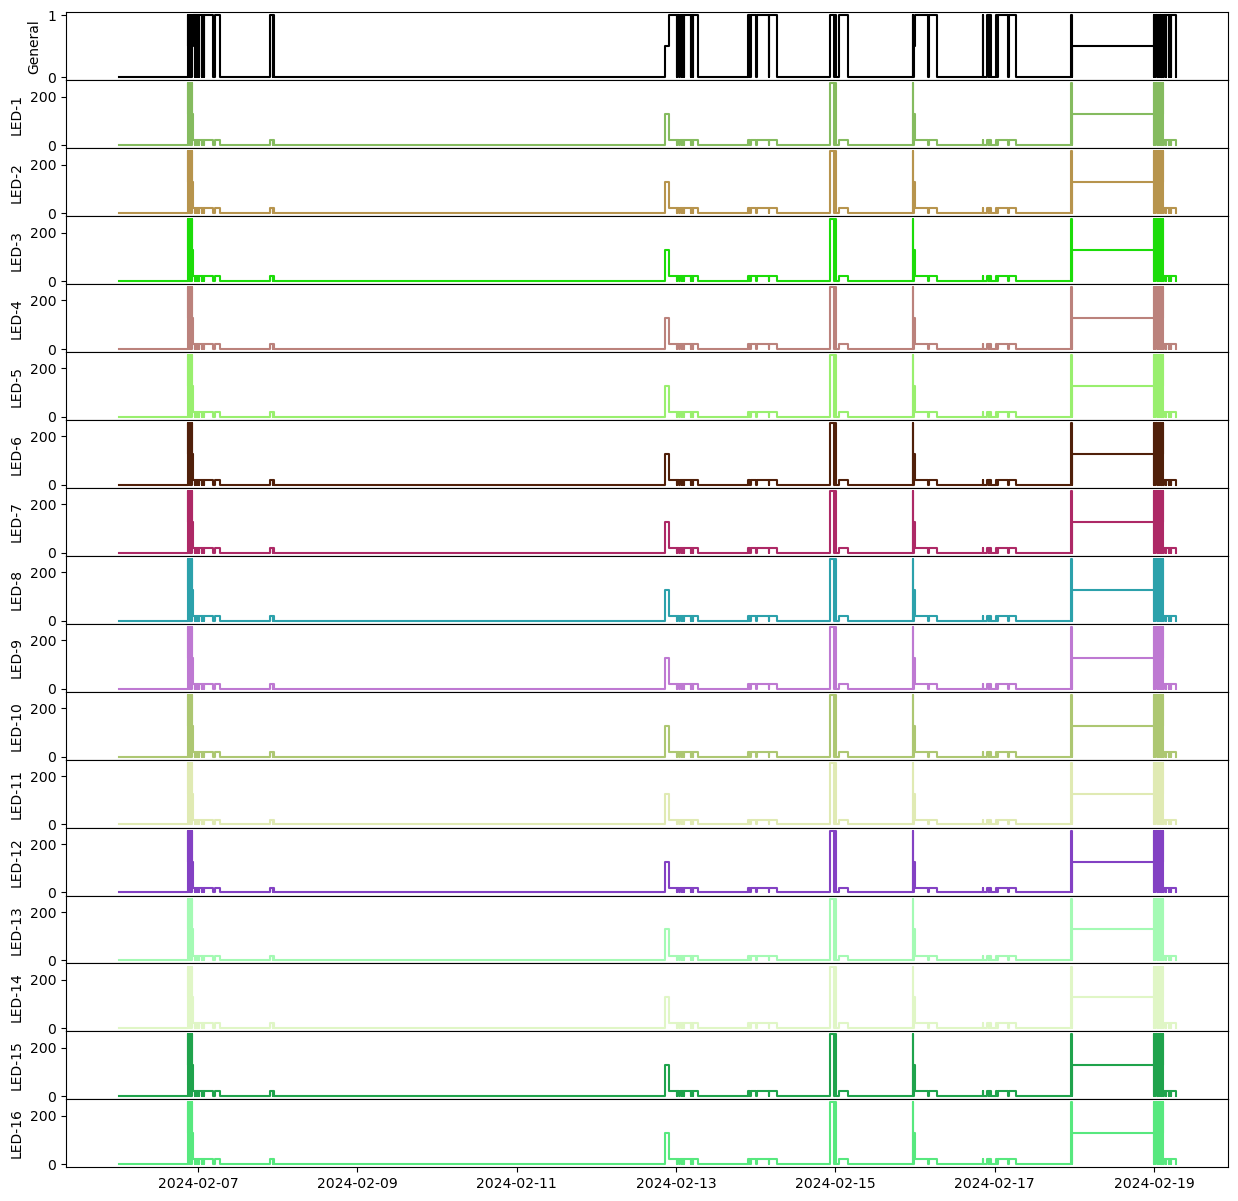

In [447]:
fig, ax = plt.subplots(len(dates_leds)+1, 1, figsize=(15, 15), sharex=True)

ax[0].plot(dates_leds_general, status_leds_general, color="k", ds="steps-post", label="LED status", zorder=10)

colors = np.random.rand(len(dates_leds), 3)
for X in range(len(dates_leds)):
    ax[X+1].plot(dates_leds[X], status_leds[X], color=colors[X], ds="steps-post", label=f"LED-{X+1} status", zorder=10)

ax[0].set_ylabel("General")
for X in range(16):
    ax[X+1].set_ylabel(f"LED-{X+1}")
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

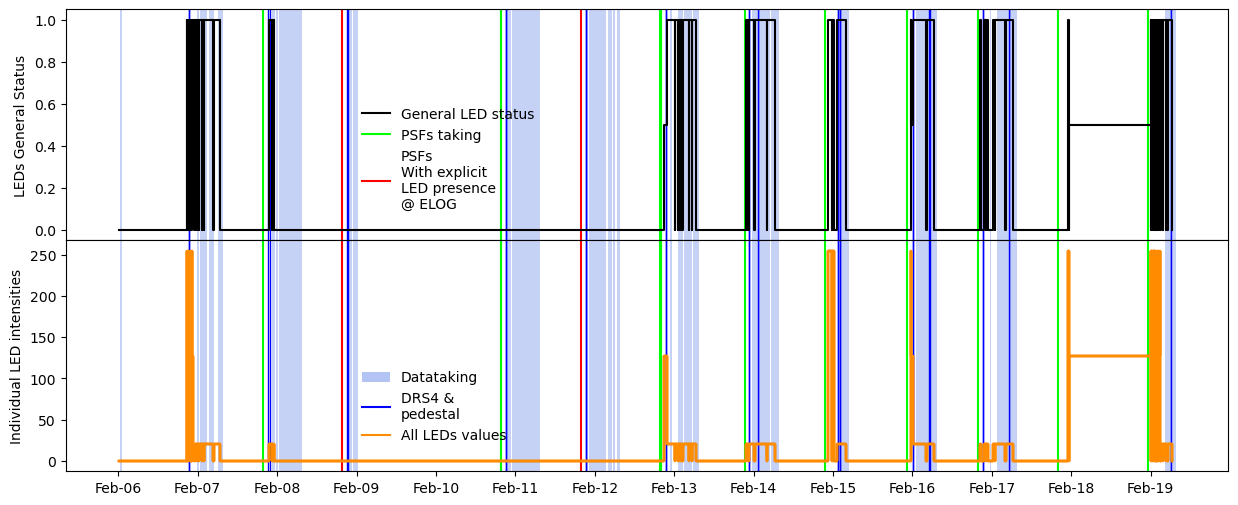

In [445]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax1.plot(dates, leds_status, color="k", ds="steps-post", label="General LED status", zorder=10)

for X in range(len(dates_leds)):
    ax2.plot(dates_leds[X], status_leds[X], color="darkorange", ds="steps-post", zorder=10)

for ax in [ax1, ax2]:
    for t in t_psf:
        ax.axvline(t, color="lime")
    for t in t_psf_error:
        ax.axvline(t, color="r")
        
    for i, doc in enumerate(tstart_tcu_drs4):
        ax.axvline(tstart_tcu_drs4[i], lw=1, color="b")
    for i, doc in enumerate(tstart_tcu_pedestal):
        ax.axvline(tstart_tcu_pedestal[i], lw=1, ls="-", color="b")
    for i, doc in enumerate(tstart_tcu_dtaking):
        ax.axvspan(tstart_tcu_dtaking[i], tstop_tcu_dtaking[i], lw=0, alpha=0.3, color="royalblue")
  
    
ax2.axvspan(None, None, alpha=0.4, lw=0, color="royalblue", label="Datataking")
ax1.plot([], [], ls="-", color="lime", label="PSFs taking")
ax1.plot([], [], ls="-", color="r", label="PSFs\nWith explicit\nLED presence\n@ ELOG")
ax2.plot([], [], ls="-", color="b", label="DRS4 &\npedestal")

ax2.plot([], [], ls="-", color="darkorange", label="All LEDs values")

ax1.set_ylabel("LEDs General Status")
ax2.set_ylabel("Individual LED intensities")
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

for ax in [ax1, ax2]:
    ax.legend(loc=(0.25, 0.1), frameon=False)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

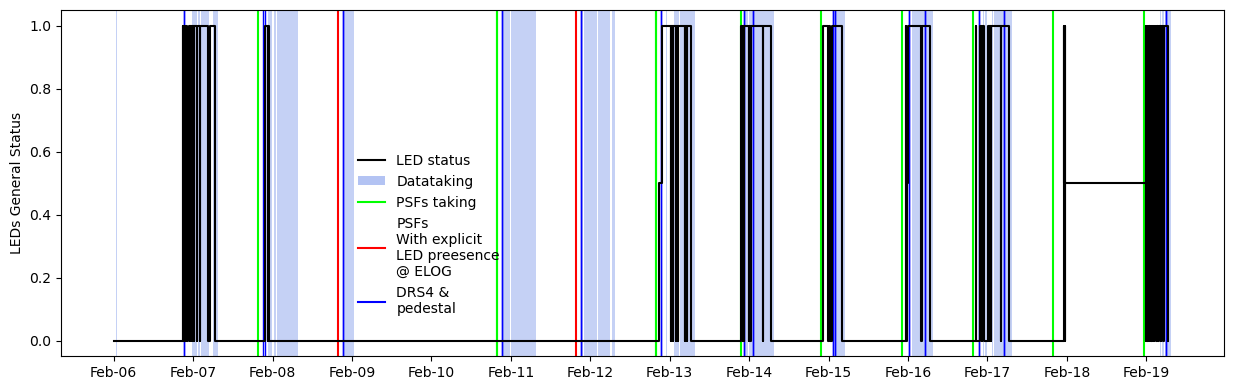

In [387]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4.5))

plt.plot(dates, leds_status, color="k", ds="steps-post", label="LED status", zorder=10)

for i, doc in enumerate(tstart_tcu_drs4):
    ax.axvline(tstart_tcu_drs4[i], lw=1, color="b")
for i, doc in enumerate(tstart_tcu_pedestal):
    ax.axvline(tstart_tcu_pedestal[i], lw=1, ls="-", color="b")
    
for i, doc in enumerate(tstart_tcu_dtaking):
    ax.axvspan(tstart_tcu_dtaking[i], tstop_tcu_dtaking[i], lw=0, alpha=0.3, color="royalblue")
    
for t in t_psf:
    ax.axvline(t, color="lime")
for t in t_psf_error:
    ax.axvline(t, color="r")
    
    
ax.axvspan(None, None, alpha=0.4, lw=0, color="royalblue", label="Datataking")
# ax.plot([], [], color="r", label="Pedestal runs")

ax.plot([], [], ls="-", color="lime", label="PSFs taking")
ax.plot([], [], ls="-", color="r", label="PSFs\nWith explicit\nLED presence\n@ ELOG")
ax.plot([], [], ls="-", color="b", label="DRS4 &\npedestal")

ax.set_ylabel("LEDs General Status")
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))  # Adjust the date format as needed
ax.legend(loc=(0.25, 0.1), frameon=False)

plt.show()

In [388]:
for i in range(len(dates)):
    print(dates[i], leds_status[i])

2024-02-06 00:09:00 0.0
2024-02-06 20:52:00 1.0
2024-02-06 20:54:00 0.0
2024-02-06 20:58:00 1.0
2024-02-06 20:59:00 0.0
2024-02-06 21:03:00 1.0
2024-02-06 21:04:00 0.0
2024-02-06 21:08:00 0.5
2024-02-06 21:13:00 0.5
2024-02-06 21:18:00 1.0
2024-02-06 21:19:00 0.0
2024-02-06 21:23:00 0.5
2024-02-06 21:29:00 0.5
2024-02-06 21:34:00 0.5
2024-02-06 21:38:00 1.0
2024-02-06 21:39:00 0.0
2024-02-06 21:52:00 1.0
2024-02-06 21:55:00 0.0
2024-02-06 21:59:00 1.0
2024-02-06 22:00:00 0.0
2024-02-06 22:12:00 1.0
2024-02-06 22:15:00 0.0
2024-02-06 22:20:00 0.5
2024-02-06 22:40:00 1.0
2024-02-06 23:02:00 0.0
2024-02-06 23:03:00 1.0
2024-02-06 23:35:00 0.0
2024-02-06 23:36:00 1.0
2024-02-06 23:45:00 0.0
2024-02-06 23:46:00 1.0
2024-02-07 00:17:00 0.0
2024-02-07 00:18:00 1.0
2024-02-07 01:11:00 0.0
2024-02-07 01:12:00 1.0
2024-02-07 01:14:00 0.0
2024-02-07 01:16:00 1.0
2024-02-07 01:57:00 0.0
2024-02-07 01:58:00 1.0
2024-02-07 04:30:00 0.0
2024-02-07 05:03:00 1.0
2024-02-07 06:36:00 0.0
2024-02-07 21:34

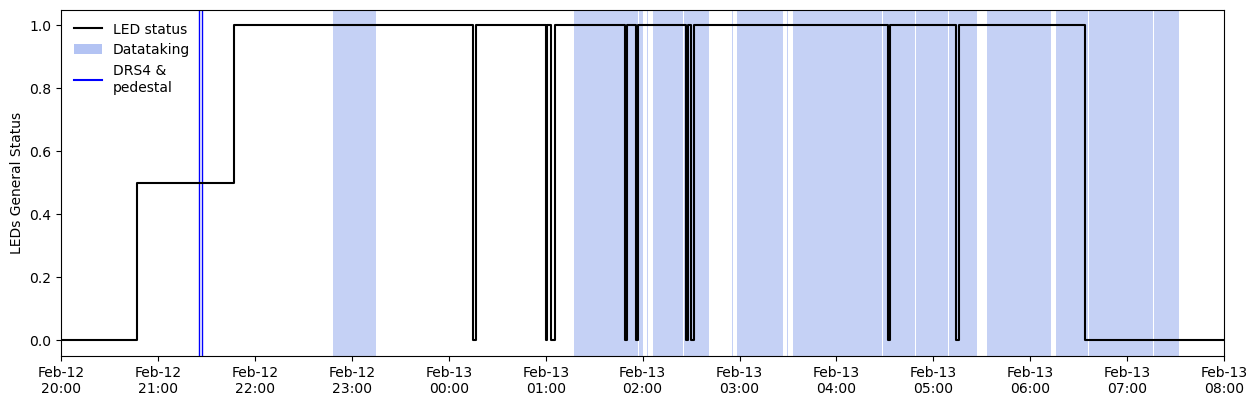

In [369]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4.5))

plt.plot(dates, leds_status, color="k", ds="steps-post", label="LED status", zorder=10)

for i, doc in enumerate(tstart_tcu_drs4):
    ax.axvline(tstart_tcu_drs4[i], lw=1, color="b")
for i, doc in enumerate(tstart_tcu_pedestal):
    ax.axvline(tstart_tcu_pedestal[i], lw=1, ls="-", color="b")
    
for i, doc in enumerate(tstart_tcu_dtaking):
    ax.axvspan(tstart_tcu_dtaking[i], tstop_tcu_dtaking[i], lw=0, alpha=0.3, color="royalblue")
    
ax.axvspan(None, None, alpha=0.4, lw=0, color="royalblue", label="Datataking")
# ax.plot([], [], color="lime", label="Pedestal runs")
ax.plot([], [], ls="-", color="b", label="DRS4 &\npedestal")
ax.set_xlim(datetime.fromisoformat("2024-02-12-20:00:00"), datetime.fromisoformat("2024-02-13-08:00:00"))

# ax.grid()
ax.set_ylabel("LEDs General Status")
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d\n%H:%M'))  # Adjust the date format as needed
ax.legend(loc=2, frameon=False)

plt.show()

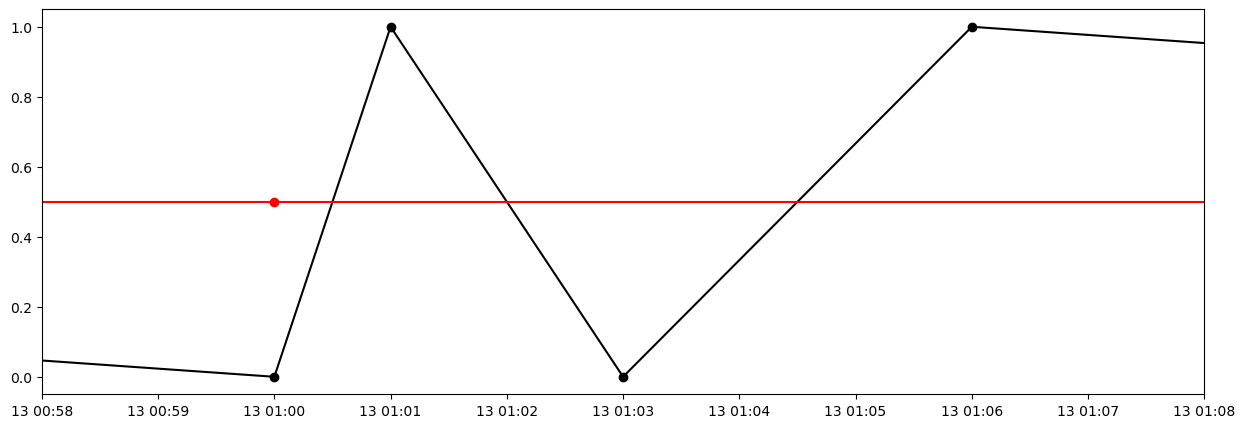

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(times[:-7], avg[:-7], "ok-");
plt.plot(times2, avg2, "or-");
plt.ylim(-0.05)
plt.xlim(datetime.fromisoformat("2024-02-13-00:58:00"), datetime.fromisoformat("2024-02-13-01:08:00"))
plt.show()

In [2]:
# extracting dates of the databases
tstart_tcu          = [datetime.utcfromtimestamp(r["tstart"])       for r in records_tcu]
tstart_caco         = [datetime.fromisoformat(r["start_time"][:-1]) for r in records_caco]
tstart_caco_runwise = [datetime.fromisoformat(r["start_time"][:-1]) for r in records_caco_runwise]

tstop_tcu          = [datetime.utcfromtimestamp(r["tstop"])       for r in records_tcu]
tstop_caco         = [datetime.fromisoformat(r["stop_time"][:-1]) for r in records_caco]
tstop_caco_runwise = [datetime.fromisoformat(r["stop_time"][:-1]) for r in records_caco_runwise]

# Finding the last run number, it should be in CaCo but we check
run_num_tcu          = []
run_num_caco         = [r["run_number"] for r in records_caco]
run_num_caco_runwise = [r["run_number"] for r in records_caco_runwise]

# Adding the run numbers of TCU
for r in records_tcu:
    # Trying, some cases there is not run number
    try:
        run_num_tcu.append(r["run_number"])
    except KeyError:
        run_num_tcu.append(None)

# Finding last run
higher_run_num = max(max(run_num_caco), max(run_num_caco_runwise))

NameError: name 'records_tcu' is not defined

# Plotting run numbers and dates for each database

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 6), sharex=True)

perc_tcu = f", {len(run_num_tcu)/higher_run_num*100:.2f}% of total"
perc_caco_runwise = f", {len(run_num_caco_runwise)/higher_run_num*100:.2f}% of total"
perc_caco =  f", {len(run_num_caco)/higher_run_num*100:.2f}% of total"

ax1.plot(tstart_tcu,          np.repeat(2, len(tstart_tcu)),          ".", c="darkblue",    label=f"TCU --> {len(records_tcu):6} entries" + perc_tcu)
ax1.plot(tstart_caco_runwise, np.repeat(1, len(tstart_caco_runwise)), ".", c="deepskyblue", label=f"CaCo run-wise --> {len(records_caco_runwise):6} entries" + perc_caco_runwise)
ax1.plot(tstart_caco,         np.repeat(0, len(tstart_caco)),         ".", c="crimson",     label=f"CaCo --> {len(records_caco):6} entries" + perc_caco)

ax2.plot(tstart_tcu, run_num_tcu,                   "o", ms=2,  c="darkblue",    label=f"TCU", zorder=10)
ax2.plot(tstart_caco_runwise, run_num_caco_runwise, "o", ms=12, c="deepskyblue", label="CaCo run-wise")
ax2.plot(tstart_caco, run_num_caco,                 "o", ms=5,  c="crimson",     label="CaCo")

date_runnumber_at_tcu     = datetime.utcfromtimestamp(records_tcu[1538]["tstart"])
str_date_runnumber_at_tcu = str(date_runnumber_at_tcu).split(" ")[0]

for ax in [ax1, ax2]:
    ax.axvline(date_runnumber_at_tcu, color="gray", ls="--", label="" if ax==ax1 else f"Last date with TCU storing no Run Number {str_date_runnumber_at_tcu}")
    ax.legend(loc=2)
    
ax1.set_yticks([])
ax1.set_ylim([-0.5, 2.5])
ax1.set_title(f"Last run number {higher_run_num}")
ax2.set_ylabel("Run number")
fig.tight_layout()
plt.show()

# Adding null run number information to TCU runs

In [ ]:
for rec in records_tcu:
    try:
        rec["run_number"]
    except KeyError:
        rec["run_number"] = np.nan

# Extracting important timestamps of databases

In [ ]:
%%time

filtered_runs        = []
t_tcu, t_c, t_c_r    = [], [], []
tt_tcu, tt_c, tt_c_r = [], [], []

for r in run_num_caco:
    
    if r in run_num_caco_runwise and r in run_num_tcu:
        
        t_c.append(   datetime.fromisoformat(   [rr for rr in records_caco         if rr["run_number"] == r][0]["start_time"][:-1]))
        t_c_r.append( datetime.fromisoformat(   [rr for rr in records_caco_runwise if rr["run_number"] == r][0]["start_time"][:-1]))
        t_tcu.append( datetime.utcfromtimestamp([rr for rr in records_tcu          if rr["run_number"] == r][0]["tstart"]))
        
        tt_c.append(  datetime.fromisoformat(   [rr for rr in records_caco         if rr["run_number"] == r][0]["stop_time"][:-1]))
        tt_c_r.append(datetime.fromisoformat(   [rr for rr in records_caco_runwise if rr["run_number"] == r][0]["stop_time"][:-1]))
        tt_tcu.append(datetime.utcfromtimestamp([rr for rr in records_tcu          if rr["run_number"] == r][0]["tstop"]))
        
        filtered_runs.append(r)
        
telapsed_tcu = np.array([(a1 - a2).total_seconds() for a1, a2 in zip(tt_tcu, t_tcu)])
telapsed_c   = np.array([(a1 - a2).total_seconds() for a1, a2 in zip(tt_c,   t_c)])
telapsed_c_r = np.array([(a1 - a2).total_seconds() for a1, a2 in zip(tt_c_r, t_c_r)])

delta_start_c_c_r = np.array([(a1 - a2).total_seconds() for a1, a2 in zip(t_c, t_c_r)])
delta_stop_c_c_r  = np.array([(a1 - a2).total_seconds() for a1, a2 in zip(tt_c, tt_c_r)])
delta_start_c_tcu = np.array([(a2 - a1).total_seconds() for a1, a2 in zip(t_c, t_tcu)])
delta_stop_c_tcu  = np.array([(a2 - a1).total_seconds() for a1, a2 in zip(tt_c, tt_tcu)])

# Distribution of time differences in start and end times

In [ ]:
N = 80
Ntime = 200
bins_start = np.linspace(0, 3, N)
bins_stop  = np.linspace(-40, -10, N)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5), sharex="col", sharey="row", gridspec_kw={'height_ratios': [1, 2.5], 'width_ratios': [2.5, 1]})

ax1.hist(delta_start_c_tcu, bins_start, color="crimson")
ax4.hist(delta_stop_c_tcu,  bins_stop,  color="darkblue", orientation="horizontal")
ax3.hist2d(delta_start, delta_stop, bins=(bins_start, bins_stop))

fig.delaxes(ax2)
plt.subplots_adjust(wspace=0, hspace=0)
ax1.set_ylabel("Counts")
ax4.set_xlabel("Counts")
ax3.set_ylabel("Stop $\\Delta t$ (t_tcu - t_caco) [s]")
ax3.set_xlabel("Start $\\Delta t$ (t_tcu - t_caco) [s]")
plt.show()

# Time distribution of the time differences

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 0.6]})

ax1.hist2d([t.timestamp() for t in t_c], delta_start_c_tcu, bins=(Ntime, bins_start))
ax3.hist2d([t.timestamp() for t in t_c], delta_stop_c_tcu,  bins=(Ntime, bins_stop))

ax2.hist(delta_start, bins_start, color="crimson", orientation="horizontal")
ax4.hist(delta_stop,  bins_stop,  color="darkblue", orientation="horizontal")

plt.subplots_adjust(wspace=0)
ax4.set_xlabel("Counts")
ax1.set_ylabel("Start $\\Delta t$ (t_tcu - t_caco) [s]")
ax3.set_ylabel("Stop $\\Delta t$ (t_tcu - t_caco) [s]")
ax2.set_xscale("log")
ax4.set_xscale("log")
ticks = ax3.get_xticks()
ax3.set_xticklabels([str(datetime.utcfromtimestamp(t))[:-12] for t in ticks])
ax3.set_xlim([np.min(t_c).timestamp(), np.max(t_c).timestamp()])
plt.show()

# Information in the databases:

In [ ]:
records_tcu[-10]

In [ ]:
for i in range(len(filtered_runs)):
    if delta_cc_stop[i] < 0:
        print(filtered_runs[i])

In [ ]:
rec1, rec2 = [r for r in records_caco if r["run_number"] == 14147]
rect      = [r for r in records_tcu if r["run_number"] == 14147]
rec1, rec2, rect

In [ ]:
rt1, rt2 = datetime.fromisoformat(rec1["start_time"][:-1]), datetime.fromisoformat(rec2["start_time"][:-1])
rtt, rttype = rect[0]["tstart"], rect[0]["kind"]
print(f"Run 14147-1:\n{rt1}\n{rt2}")
print(f"\nTCU timestamp:\n{datetime.utcfromtimestamp(rtt)} --> {rttype}")

In [ ]:
for i in range(len(records_caco[:])):
    
    rec = records_caco[i]
    run_1 = rec["run_number"]
    if run_1 == 0 or run_1 == 1:
        stime = datetime.fromisoformat(rec["start_time"][:-1]).replace(microsecond=0)
        
        tstart, tstop = datetime.fromisoformat(rec["start_time"][:-1]), datetime.fromisoformat(rec["stop_time"][:-1])
        delta = (tstop - tstart).total_seconds()/60
        a, b = records_caco[i-1]["run_number"], records_caco[i+1]["run_number"]
        print(f"\nFor run from {stime}:\nrun_id = {run_1}\nbefore/after run: {a}/{b}\nlasted = {delta:.1f} min")

In [ ]:
for i in range(len(records_tcu[:])):
    
    rec = records_tcu[i]
    run_1 = rec["run_number"]
    if run_1 == 0 or run_1 == 1 and run_1 != np.nan:
        stime = datetime.utcfromtimestamp(rec["tstart"]).replace(microsecond=0)
        
        tstart, tstop = datetime.utcfromtimestamp(rec["tstart"]), datetime.utcfromtimestamp(rec["tstop"])
        delta = (tstop - tstart).total_seconds()/60
        a, b = records_caco[i-1]["run_number"], records_caco[i+1]["run_number"]
        kind = rec["kind"]
        print(f"\nFor run from {stime}:\nrun_id = {run_1}\nbefore/after run: {a}/{b}\nlasted = {delta:.1f} min")
        print(f"run type: {kind}")

In [ ]:
a = datetime.utcfromtimestamp(ticks[0])
str(a)[:-12]

In [ ]:

for record in records_tcu[:100]:
    
    tstart = round_s(datetime.utcfromtimestamp(record["tstart"]))
    tstop  = round_s(datetime.utcfromtimestamp(record["tstop"]))
    
    run_dict_caco = [rec for rec in records_caco if round_s(datetime.fromisoformat(rec["start_time"][:-1])) == tstart]

    if len(run_dict_caco) > 0:

        c += 1
        print(run_dict_caco[0]["run_number"])
        
        record["run_number"] = run_dict_caco[0]["run_number"]
    else:
        print("----")

In [ ]:
[r for r in records_caco if r["run_number"] == rr][0]["start_time"]

In [ ]:
rr = 6707

print(datetime.fromisoformat([r for r in records_caco if r["run_number"] == rr][0]["start_time"][:-1]))
# print(round_s(datetime.utcfromtimestamp([records_tcu.index(r) for r in records_tcu if r["run_number"] == rr][0]["tstart"])))

print(datetime.utcfromtimestamp(records_tcu[2]["tstart"]))

In [ ]:
rr = 6707

print(datetime.fromisoformat([r for r in records_caco if r["run_number"] == rr][0]["stop_time"][:-1]))
# print(round_s(datetime.utcfromtimestamp([records_tcu.index(r) for r in records_tcu if r["run_number"] == rr][0]["tstart"])))

print(datetime.utcfromtimestamp(records_tcu[2]["tstop"]))

In [ ]:
rr = 6707

round_s(datetime.fromisoformat([r for r in records_caco if r["run_number"] == rr][0]["start_time"][:-1]))

In [ ]:
round_s(datetime.fromisoformat(records_caco[105]["start_time"][:-1]))

In [ ]:
for rec in records_tcu:
    try:
        rec["run_number"]
    except KeyError:
        rec["run_number"] = np.nan

In [ ]:
def get_run_num_tcu(recs):
    run_numbers = []
    for rec in recs:
        try:
            run_numbers.append(rec["run_number"])
        except KeyError:
            pass
    return np.array(run_numbers)


run_num_tcu  = get_run_num_tcu(records_tcu)
run_num_caco = np.array([rec["run_number"] for rec in records_caco])

tstart_tcu  = np.array([datetime.utcfromtimestamp(rec["tstart"])       for rec in records_tcu])
tstop_tcu   = np.array([datetime.utcfromtimestamp(rec["tstop"])        for rec in records_tcu])
tstart_caco = np.array([datetime.fromisoformat(rec["start_time"][:-1]) for rec in records_caco])
tstop_caco  = np.array([datetime.fromisoformat(rec["stop_time"][:-1])  for rec in records_caco])

deltat_tcu = tstop_tcu - tstart_tcu
deltat_caco = tstop_caco - tstart_caco

In [ ]:
higher_run = max(np.nanmax(run_num_caco), np.nanmax(run_num_tcu))

for run in np.arange(higher_run+1)[-1000:-990]:
    
    run_dict_caco = [rec for rec in records_caco if rec["run_number"] == run]
    isincaco = len(run_dict_caco) > 0
    
    run_dict_tcu = [rec for rec in records_tcu if rec["run_number"] == run]
    isintcu = len(run_dict_tcu) > 0

    if isincaco and isintcu:
        col = "92"
    elif isincaco or isintcu:
        col = "93"
    else:
        col = "91"
        
    if isintcu:
        end = "type --> "+run_dict_tcu[0]["kind"]
    else:
        end = ""
    if len(run_dict_tcu) == 2:
        end = end + " - 2 same run_num TCU runs!!!!!"
    
    print(f"\033[{col}mRun {run}  inCaCo: {isincaco} \tinTCU: {isintcu}\t{end}")
    
    try:
        T = round_s(datetime.utcfromtimestamp(run_dict_tcu[0]["tstart"]))
    except:
        T=0
    
    print(round_s(datetime.fromisoformat(run_dict_caco[0]["start_time"][:-1])), ' -- ',T, ' --> ',round_s(datetime.fromisoformat(run_dict_caco[0]["start_time"][:-1])) == T)

In [ ]:
plt.scatter([t.timestamp() for t in tstart_caco], 
            [d.total_seconds() for d in deltat_caco], 
            marker=".")
plt.scatter([t.timestamp() for t in tstart_tcu], 
            [d.total_seconds() for d in deltat_tcu], 
            marker=".")
plt.show()

In [ ]:
plt.hist([d.total_seconds()/3600 for d in deltat_tcu], 100);
plt.hist([d.total_seconds()/3600 for d in deltat_caco], 100);

In [ ]:
import datetime
datetime.datetime.fromtimestamp(1643933651.8415616)

In [ ]:
mongo_client = pymongo.MongoClient('localhost:27017')

db = mongo_client['lst1_obs_summary']
# col = db["RUN_INFORMATION"]


# # query = dict()

# # query.update({"tstart": {"$gte": datetime.datetime.fromisoformat(tstart).timestamp()}})
# # query.update({"tstop": {"$lte": datetime.datetime.fromisoformat(tstop).timestamp()}})

# response = col.find()


# records = tuple(
#     doc for doc in response
# )

In [ ]:
db.list_collection_names()

In [ ]:
mongo_client.list_database_names()

In [ ]:
records[0]

In [ ]:
records[1001]["config"]["caco"][0].keys()

In [ ]:
{
  "run_number": 2103,
  "start_time": "2020-06-18T02:44:37.585Z",
  "stop_time": "2020-06-18T02:45:02.742Z",
  "tib": {
    "DigitalPedestalConfigRate": 0,
    "AnalogPedestalEnable": false,
    "PedestalRate": 0.0,
    "CameraRate": 1868.0,
    "FakeTriggerEnable": false,
    "PeriodicPedestalFrequency": 0,
    "PedestalEnable": false,
    "PeriodicPedestalEnable": false,
    "valid": true,
    "LocalRate": 2167.0,
    "SoftwareTriggerEnable": false,
    "DelayLocal": 0.0,
    "SlowControlEnable": false,
    "CalibrationRate": 0.0,
    "MonoEnable": false,
    "BUSYRate": 34.0,
    "CollectedRate": 1902.0,
    "InputMask": 0,
    "CalibrationEnable": false,
    "DigitalPedestalEnable": false,
    "AnalogPedestalThreshold": 0.0,
    "SoftwareTriggerRate": 0.0
  },
  "cbox": {
    "valid": true,
    "hz": "No available",
    "wheel1_position": "No available",
    "temperature": "No available",
    "duty": "No available",
    "humidity": "No available",
    "wheel2_position": "No available",
    "cycles": "No available"
  }
}

* Run number
* Time start/stop
* Kind of run data_takin/calib_drs4...
* configuration used
    * camera
    * caco
        * Name of command
        * data - xml file
        * application time
    * cbox
* health
    * local rate
        * min/max/mean
    * anode_current
        * min/max/mean